# Installs & Imports

In [1]:
!pip install -q optuna

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import os
import optuna

%matplotlib inline

# Load the Data

In [3]:
# Load the data
def load_data():
    data = load_iris()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target, name='species')
    target_names = data.target_names
    return X, y, target_names

# Load the data
X, y, target_names = load_data()

# Display the data
print("Features:")
display(X.head())
print("\nTarget:")
display(y.head())

Features:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2



Target:


,species
0,0
1,0
2,0
3,0
4,0


# Nested Cross-Validation

In [4]:
# Nested Cross-Validation class
class NestedCrossValidatorOptuna:
    def __init__(self, outer_splits=5, inner_splits=5, random_state=42, n_trials=50):
        self.outer_splits = outer_splits
        self.inner_splits = inner_splits
        self.random_state = random_state
        self.n_trials = n_trials  # Number of Optuna trials
        self.outer_cv = StratifiedKFold(n_splits=self.outer_splits, shuffle=True, random_state=self.random_state)
        self.inner_cv = StratifiedKFold(n_splits=self.inner_splits, shuffle=True, random_state=self.random_state)
        self.models = self._initialize_models()
        self.best_model_name = None
        self.best_model = None
        self.best_score = -np.inf

    def _initialize_models(self):
        """Initialize models with hyperparameter grids."""
        models = {
            'RandomForest': RandomForestClassifier(random_state=self.random_state),
            'SVM': SVC(random_state=self.random_state)
        }
        return models

    def _create_pipeline(self, model):
        """Create a machine learning pipeline with scaling and the given model."""
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Feature scaling
            ('model', model)
        ])
        return pipeline

    def _objective(self, trial, model_name, X, y):
        """Objective function for Optuna hyperparameter tuning."""
        if model_name == 'RandomForest':
            n_estimators = trial.suggest_int('model__n_estimators', 10, 100)
            max_depth = trial.suggest_int('model__max_depth', 2, 32, log=True)
            min_samples_split = trial.suggest_int('model__min_samples_split', 2, 10)
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=self.random_state
            )
        elif model_name == 'SVM':
            C = trial.suggest_float('model__C', 1e-3, 1e2, log=True)
            kernel = trial.suggest_categorical('model__kernel', ['linear', 'rbf'])
            gamma = trial.suggest_categorical('model__gamma', ['scale', 'auto'])
            model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=self.random_state)

        pipeline = self._create_pipeline(model)

        # Use cross_val_score for evaluation within Optuna
        scores = cross_val_score(pipeline, X, y, cv=self.inner_cv, scoring='accuracy', n_jobs=-1)
        return scores.mean()

    def _train_and_evaluate_model(self, X, y, model_name):
        """Train and evaluate a single model using nested cross-validation."""
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: self._objective(trial, model_name, X, y), n_trials=self.n_trials)

        print(f"{model_name} - Best Trial Accuracy: {study.best_value:.4f}")
        print(f"Best parameters for {model_name}: {study.best_params}")

        # Train on the entire dataset using the best found hyperparameters
        best_model = self._create_pipeline(self.models[model_name])
        best_model.set_params(**study.best_params)
        best_model.fit(X, y)

        # Update the best model if this one is better
        if study.best_value > self.best_score:
            self.best_score = study.best_value
            self.best_model_name = model_name
            self.best_model = best_model

        # Evaluate on the full dataset
        y_pred = best_model.predict(X)
        report = classification_report(y, y_pred, output_dict=True)
        print(f"Classification report for {model_name}:\n")
        print(classification_report(y, y_pred))

        return best_model, y_pred, study.best_value, report

    def _plot_feature_importances(self, model, X, model_name):
        """Plot feature importances for tree-based models."""
        feature_importances = model.named_steps['model'].feature_importances_
        feature_names = X.columns
        plt.figure(figsize=(10, 8))
        sns.barplot(x=feature_importances, y=feature_names)
        plt.title(f"Feature Importances - {model_name}")
        plt.show()

    def _export_results(self, y_true, y_pred, model_name, results_dir):
        """Export the results to a CSV file."""
        result_df = pd.DataFrame({
            'True Labels': y_true,
            'Predicted Labels': y_pred
        })
        result_df.to_csv(os.path.join(results_dir, f"{model_name}_results.csv"), index=False)
        print(f"Results exported to {results_dir}/{model_name}_results.csv")

    def _plot_confusion_matrix(self, y_true, y_pred, model_name, target_names):
        """Plot confusion matrix for model predictions."""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    def perform_nested_cv(self, X, y, target_names, export_results=False, results_dir="results"):
        """Perform nested cross-validation for all models and return the best model."""
        if export_results and not os.path.exists(results_dir):
            os.makedirs(results_dir)

        results = {}

        for model_name in self.models.keys():
            print(f"Performing nested cross-validation for {model_name}...")

            best_model, y_pred, best_score, report = self._train_and_evaluate_model(X, y, model_name)

            results[model_name] = {
                'best_score': best_score,
                'classification_report': report
            }

            # Plot confusion matrix
            self._plot_confusion_matrix(y, y_pred, model_name, target_names)

            # Plot feature importances for tree-based models
            if model_name == 'RandomForest':
                self._plot_feature_importances(best_model, X, model_name)

            # Export results if needed
            if export_results:
                self._export_results(y, y_pred, model_name, results_dir)

        # Print the best model and its parameters
        print(f"\nBest Model: {self.best_model_name}")
        print(f"Best Nested CV Accuracy: {self.best_score:.4f}")
        print(f"Best Hyperparameters: {results[self.best_model_name]}")

        return results, self.best_model

[I 2024-08-26 01:50:19,185] A new study created in memory with name: no-name-ed7911be-8d80-402c-af6b-78b6db7499a1


Performing nested cross-validation for RandomForest...


[I 2024-08-26 01:50:24,087] Trial 0 finished with value: 0.9666666666666668 and parameters: {'model__n_estimators': 85, 'model__max_depth': 7, 'model__min_samples_split': 4}. Best is trial 0 with value: 0.9666666666666668.
[I 2024-08-26 01:50:25,623] Trial 1 finished with value: 0.9666666666666668 and parameters: {'model__n_estimators': 56, 'model__max_depth': 5, 'model__min_samples_split': 5}. Best is trial 0 with value: 0.9666666666666668.
[I 2024-08-26 01:50:27,207] Trial 2 finished with value: 0.9533333333333335 and parameters: {'model__n_estimators': 70, 'model__max_depth': 2, 'model__min_samples_split': 9}. Best is trial 0 with value: 0.9666666666666668.
[I 2024-08-26 01:50:28,067] Trial 3 finished with value: 0.9600000000000002 and parameters: {'model__n_estimators': 26, 'model__max_depth': 4, 'model__min_samples_split': 8}. Best is trial 0 with value: 0.9666666666666668.
[I 2024-08-26 01:50:29,159] Trial 4 finished with value: 0.9600000000000002 and parameters: {'model__n_estim

RandomForest - Best Trial Accuracy: 0.9667
Best parameters for RandomForest: {'model__n_estimators': 85, 'model__max_depth': 7, 'model__min_samples_split': 4}
Classification report for RandomForest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



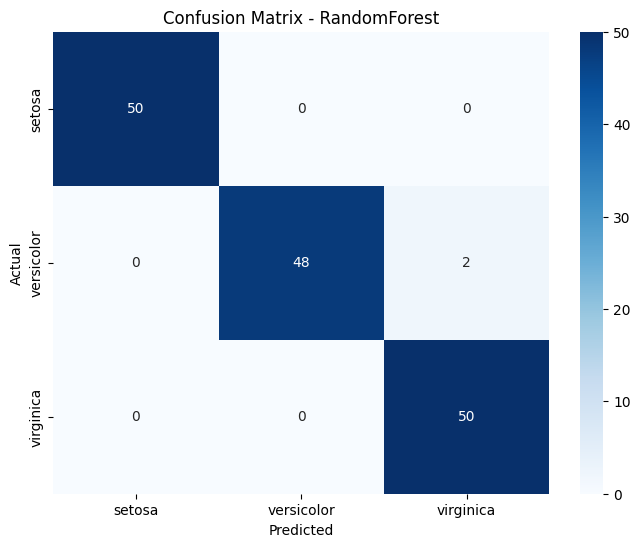

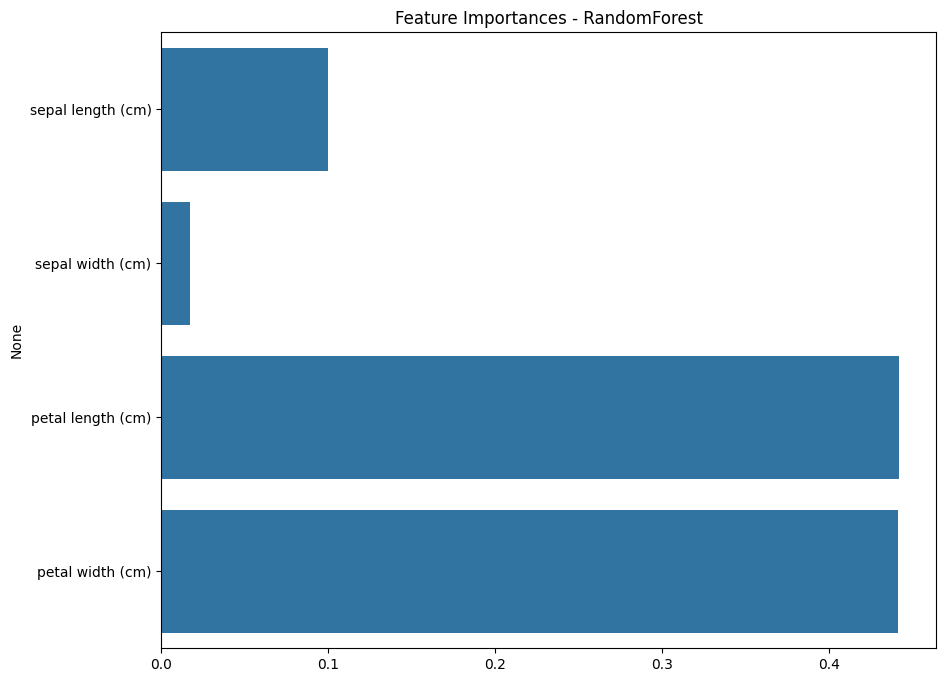

[I 2024-08-26 01:51:18,394] A new study created in memory with name: no-name-15c5caa6-8d50-4eab-b0e6-ef05280ac16f
[I 2024-08-26 01:51:18,465] Trial 0 finished with value: 0.8866666666666667 and parameters: {'model__C': 0.0380174040198314, 'model__kernel': 'rbf', 'model__gamma': 'scale'}. Best is trial 0 with value: 0.8866666666666667.
[I 2024-08-26 01:51:18,516] Trial 1 finished with value: 0.9600000000000002 and parameters: {'model__C': 0.37704328967511647, 'model__kernel': 'rbf', 'model__gamma': 'scale'}. Best is trial 1 with value: 0.9600000000000002.
[I 2024-08-26 01:51:18,566] Trial 2 finished with value: 0.8866666666666667 and parameters: {'model__C': 0.0011433713908808537, 'model__kernel': 'rbf', 'model__gamma': 'scale'}. Best is trial 1 with value: 0.9600000000000002.


Results exported to results/RandomForest_results.csv
Performing nested cross-validation for SVM...


[I 2024-08-26 01:51:18,616] Trial 3 finished with value: 0.9466666666666667 and parameters: {'model__C': 36.404187476370545, 'model__kernel': 'rbf', 'model__gamma': 'scale'}. Best is trial 1 with value: 0.9600000000000002.
[I 2024-08-26 01:51:18,666] Trial 4 finished with value: 0.9533333333333334 and parameters: {'model__C': 0.07101993034418881, 'model__kernel': 'linear', 'model__gamma': 'scale'}. Best is trial 1 with value: 0.9600000000000002.
[I 2024-08-26 01:51:18,717] Trial 5 finished with value: 0.8933333333333333 and parameters: {'model__C': 0.07775862216995534, 'model__kernel': 'rbf', 'model__gamma': 'auto'}. Best is trial 1 with value: 0.9600000000000002.
[I 2024-08-26 01:51:18,768] Trial 6 finished with value: 0.8866666666666667 and parameters: {'model__C': 0.0122197873265807, 'model__kernel': 'rbf', 'model__gamma': 'auto'}. Best is trial 1 with value: 0.9600000000000002.
[I 2024-08-26 01:51:18,819] Trial 7 finished with value: 0.9666666666666666 and parameters: {'model__C': 

SVM - Best Trial Accuracy: 0.9800
Best parameters for SVM: {'model__C': 7.681386183615186, 'model__kernel': 'linear', 'model__gamma': 'auto'}
Classification report for SVM:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.94      0.96        50
           2       0.94      0.98      0.96        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



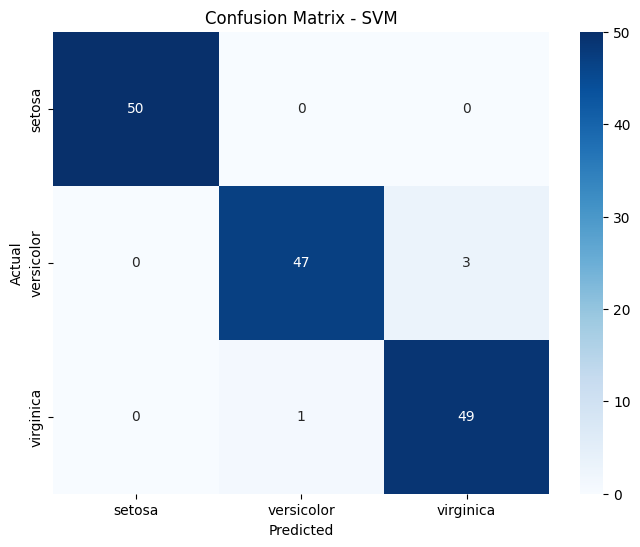

Results exported to results/SVM_results.csv

Best Model: SVM
Best Nested CV Accuracy: 0.9800
Best Hyperparameters: {'best_score': 0.9800000000000001, 'classification_report': {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 50.0}, '1': {'precision': 0.9791666666666666, 'recall': 0.94, 'f1-score': 0.9591836734693877, 'support': 50.0}, '2': {'precision': 0.9423076923076923, 'recall': 0.98, 'f1-score': 0.9607843137254902, 'support': 50.0}, 'accuracy': 0.9733333333333334, 'macro avg': {'precision': 0.9738247863247862, 'recall': 0.9733333333333333, 'f1-score': 0.9733226623982927, 'support': 150.0}, 'weighted avg': {'precision': 0.9738247863247864, 'recall': 0.9733333333333334, 'f1-score': 0.9733226623982927, 'support': 150.0}}}


In [5]:
# Initialize the NestedCrossValidatorOptuna
validator = NestedCrossValidatorOptuna(n_trials=50)

# Perform nested cross-validation and get the best model
results, best_model = validator.perform_nested_cv(X, y, target_names, export_results=True)

# Further Evaluation

In [6]:
# Function to generate bootstrap samples
def bootstrap_sampling(X, y, n_iterations=100, random_state=42):
    """Generate bootstrap samples from the original dataset."""
    np.random.seed(random_state)
    bootstrap_samples = []

    for i in range(n_iterations):
        # Generate a bootstrap sample
        X_resampled, y_resampled = resample(X, y, random_state=random_state + i)
        bootstrap_samples.append((X_resampled, y_resampled))

    return bootstrap_samples

In [7]:
# Generate bootstrap samples
bootstrap_samples = bootstrap_sampling(X, y, n_iterations=100)

In [8]:
# Function to evaluate model performance
def evaluate_bootstrap_samples(model, bootstrap_samples):
    """Evaluate the model on bootstrap samples and return the scores."""
    bootstrap_scores = []

    for X_resampled, y_resampled in bootstrap_samples:
        # Evaluate the model on the bootstrap sample
        score = model.score(X_resampled, y_resampled)
        bootstrap_scores.append(score)

    # Calculate the mean and 95% confidence interval of the scores
    mean_score = np.mean(bootstrap_scores)
    ci_lower = np.percentile(bootstrap_scores, 2.5)
    ci_upper = np.percentile(bootstrap_scores, 97.5)

    print(f"Bootstrap Mean Accuracy: {mean_score:.4f}")
    print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

    return bootstrap_scores, mean_score, (ci_lower, ci_upper)

In [9]:
# Evaluate the best model using the bootstrap samples
bootstrap_scores, mean_score, confidence_interval = evaluate_bootstrap_samples(best_model, bootstrap_samples)

Bootstrap Mean Accuracy: 0.9733
95% Confidence Interval: [0.9498, 0.9933]
